# Micrograd

This notebook follows karpathy's video [here](https://www.youtube.com/watch?v=VMj-3S1tku0).

In [74]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
def f(x):
    return 3*x**2 - 4*x + 5

In [76]:
f(3.0)

20.0

In [77]:
xs = np.arange(-5, 5, .25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

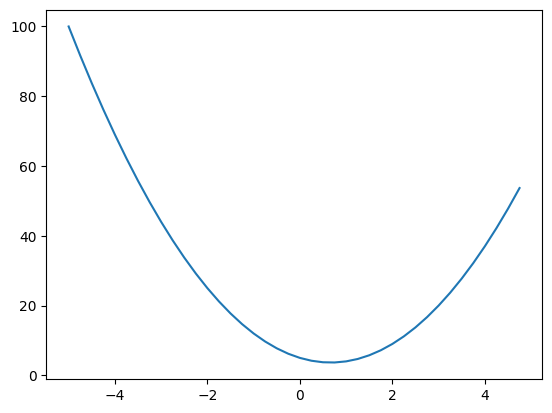

In [78]:
ys = f(xs)
plt.plot(xs, ys)

In [79]:
h = .001
x = 3.0
(f(x + h) - f(x)) / h # numerical approx of the slope

14.00300000000243

In [80]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
d

4.0

The following computes the slope. The result is b.

In [81]:
h = .00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


In [82]:
h = .00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.00002
slope 2.0000000000131024


Let's automate this process as neural networks are very complex.

In [83]:
class Value:

    # When creating a Value from an operation,
    # populate the set.
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")

In [84]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d * f; L.label = "Loss"

print(d._prev, d._op)

{Value(data=-6.0), Value(data=10.0)} +


Visualize complex graphs.

In [85]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "%s | data %.4f" % (n.label, n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

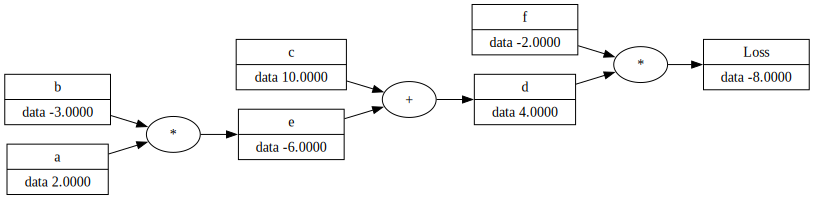

In [86]:
draw_dot(L)

Let's apply backpropagation. For every single value, we are going to compute the derivative w.r.t. the Loss.

In [87]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "%s | data %.4f | grad %.4f" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

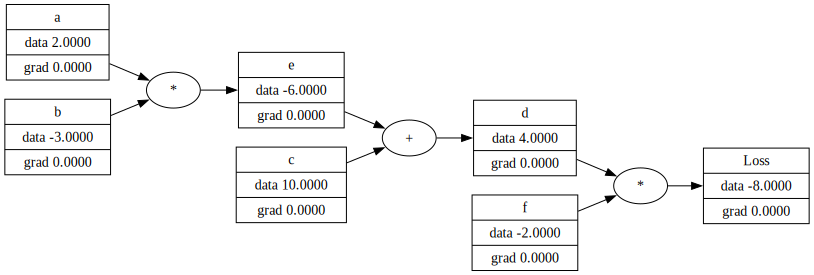

In [88]:
def scope():
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"

    return draw_dot(L)

scope()

What is the derivative of L w.r.t. L? Answer is 1. The change will be proportional.

In [89]:
L.grad = 1.0

$
L = d * f
$

$
DL/dd =? f
$

We can apply the formula:
$(f(x + h) - f(x)) / h$

$dL/dd = ((d + h) * f - d * f) / h = f * h / h = f = -2.0$

Similarly, $dL/df = d = 4.0$

Let's check $DL/dd$ numerically using a small step size

In [90]:
def lol():
    h = 0.00001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"
    L1 = L.data

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    d.data += h # nudging the input
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"
    L2 = L.data

    print((L2 - L1) / h)

lol()

-1.9999999999242843


$
d = c + e
$

$
dd/dc =? 1
$

$
(c + h + e - (c + e)) / h = 1
$

Now that we understood the gradient for individual nodes, let's apply the linear rule.

Want: $DL/dc$

Know: $DL/dd$, $dd/dc$

$
DL/dc = DL/dd * dd/dc = -2.0 * 1.0 = -2.0
$

Observation: the + node just routes the gradient

In [91]:
def lol():
    h = 0.00001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"
    L1 = L.data

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0 + h, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"
    L2 = L.data

    print((L2 - L1) / h)

lol()

-1.9999999999242843


What about $dL/da$? Applying the chain rule, $dL/da = dL/dd * dd/de * de/da$

Know: $dd/de = 1$

$e = a * b$
$de/da =? b$

Again we can apply the formula just to check

$
((a + h) * b - a * b) / h = b
$

So we get $dL/da = -2.0 * -3.0 = 6.0$

Similarly, $dL/db = -2.0 * 2.0 = -4.0$

In [92]:
def lol():
    h = 0.00001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"
    L1 = L.data

    a = Value(2.0 + h, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"
    L2 = L.data

    print((L2 - L1) / h)

lol()

6.000000000128124


Let's simulate a single optimization step. We plug all gradients calculated above manually.

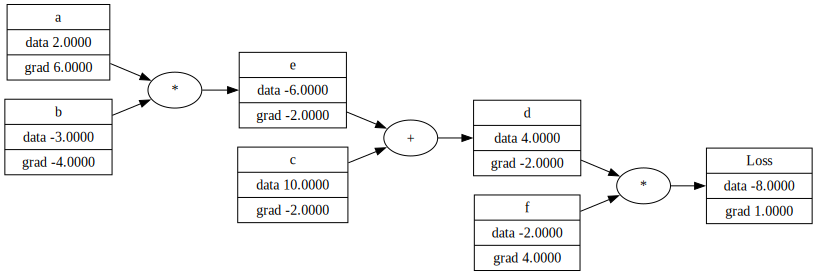

In [93]:
def lol():
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"

    L.grad = 1.0
    f.grad = 4.0
    e.grad = -2.0
    d.grad = -2.0
    c.grad = -2.0
    b.grad = -4.0
    a.grad = 6.0

    return draw_dot(L)

lol()

If we go in the direction of the gradient, we will increase $L$

In [94]:
def lol():
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "Loss"
    print(L)

    L.grad = 1.0
    f.grad = 4.0
    e.grad = -2.0
    d.grad = -2.0
    c.grad = -2.0
    b.grad = -4.0
    a.grad = 6.0

    # We have control on the leaf nodes
    rate = 0.01
    a.data += rate * a.grad
    b.data += rate * b.grad
    c.data += rate * c.grad
    f.data += rate * f.grad

    # Forward pass
    e = a * b
    d = c + e
    L = d * f
    print(L)

lol()

Value(data=-8.0)
Value(data=-7.286496)


## Backpropagate through a neuron

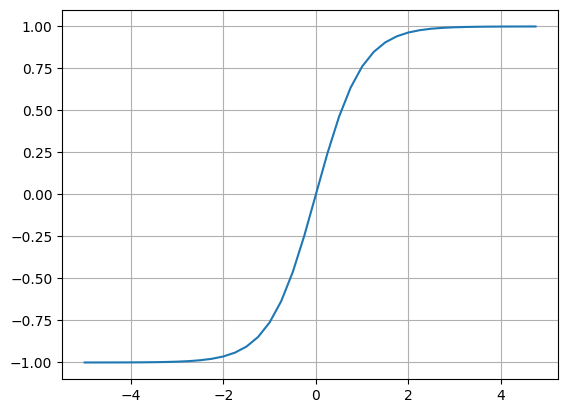

In [95]:
plt.plot(np.arange(-5, 5, .25), np.tanh(np.arange(-5, 5, .25)))
plt.grid()

tanh in an hyperbolic function. As long as we know the local derivative for it, we can use it in the neural net.

In [96]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")
    
    def tanh(self):
        n = self.data
        out = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        return Value(out, (self, ), "tanh")

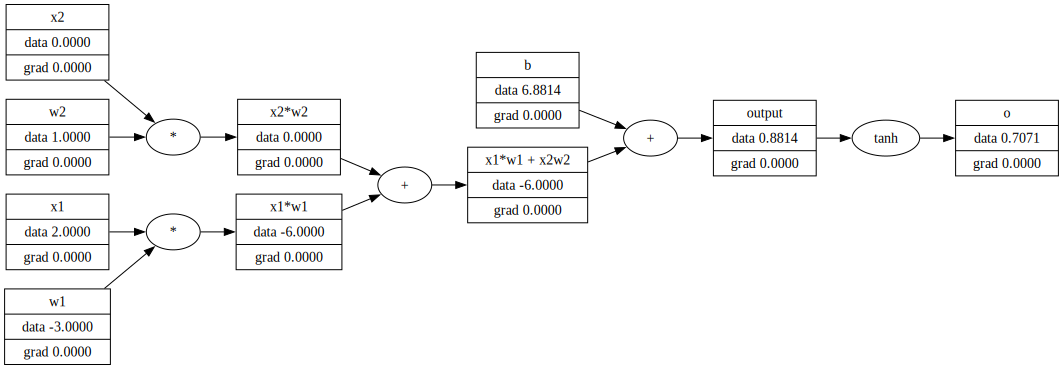

In [97]:
#inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias
b = Value(6.8813735870, label="b")

# x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2w2"
output = x1w1x2w2 + b; output.label = "output"

o = output.tanh(); o.label = "o"
draw_dot(o)

Manual backprop :)

In [98]:
o.grad = 1.0

$
o = tanh(output)
$

$
do/doutput = 1 - o**2
$

In [99]:
1 - o.data**2

0.5000000000138193

output.grad = 0.5

Local derivative for inputs of a plus operation is 1.0. Let's backpropagate using the chain rule.

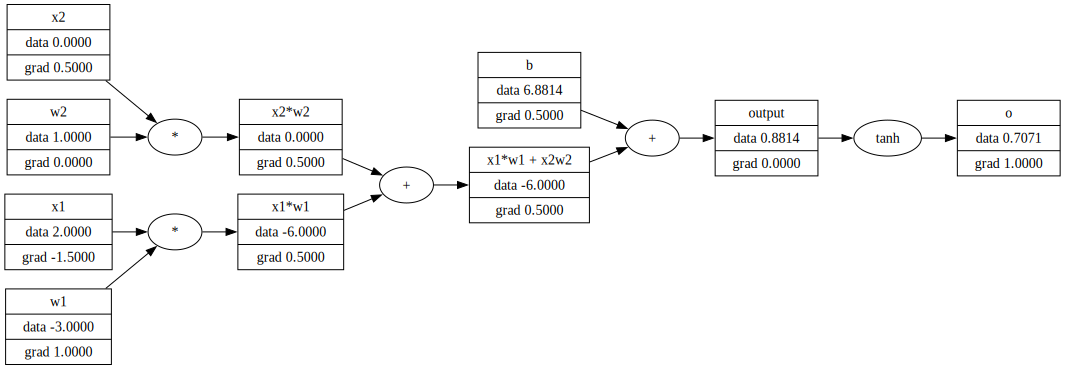

In [100]:
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

draw_dot(o)

So changing the value of w2 won't have any effect on the output as gradient is null. If we change w1, the output will change proportionally.

## Implement autograd 

Let's add a backward function to each Value, in order to specify how to chain the output gradients into the input gradients.

In [101]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
    
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out

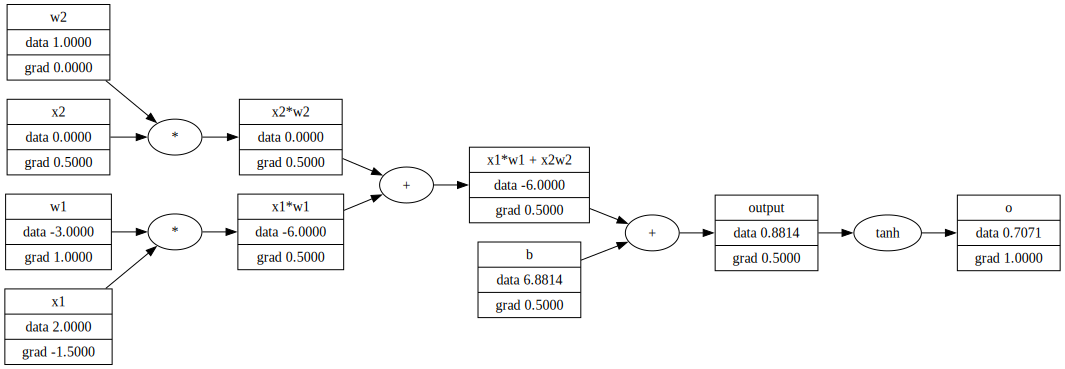

In [102]:
def lol():
    #inputs x1, x2
    x1 = Value(2.0, label="x1")
    x2 = Value(0.0, label="x2")

    # weights
    w1 = Value(-3.0, label="w1")
    w2 = Value(1.0, label="w2")

    # bias
    b = Value(6.8813735870, label="b")

    # x1 * w1 + x2 * w2 + b
    x1w1 = x1 * w1; x1w1.label = "x1*w1"
    x2w2 = x2 * w2; x2w2.label = "x2*w2"
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2w2"
    output = x1w1x2w2 + b; output.label = "output"

    o = output.tanh(); o.label = "o"

    # We have to init the ouput gradient to 1.0, because of the mul in tanh's derivative
    o.grad = 1.0
    o._backward()
    output._backward()
    b._backward() # does nothing as it is a lead node
    x1w1x2w2._backward()
    x1w1._backward()
    x2w2._backward()

    return draw_dot(o)

lol()

How to call backward automatically? We'll use a topological sort to make sure that nodes are visited in order.

In [103]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo

[Value(data=6.881373587),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735869999997),
 Value(data=0.7071067811767758)]

Before coming up with the final version of Value, we fix a bug surfacing in cases where a node is used more than once for backprop. In this case, gradients need to be accumulated with +=.

In [107]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

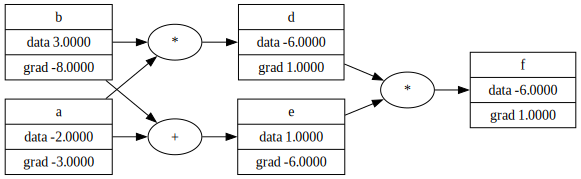

In [108]:
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a * b; d.label = "d"
e = a + b; e.label = "e"
f = d * e; f.label = "f"
f.backward()
draw_dot(f)

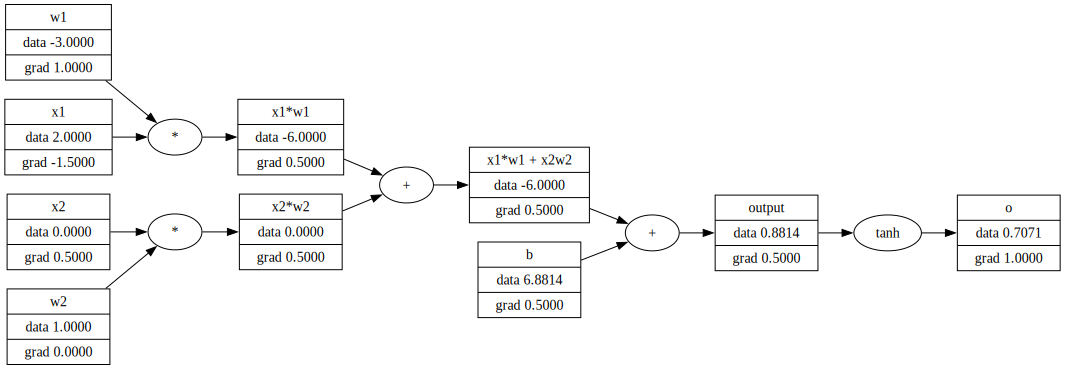

In [106]:
def lol():
    #inputs x1, x2
    x1 = Value(2.0, label="x1")
    x2 = Value(0.0, label="x2")

    # weights
    w1 = Value(-3.0, label="w1")
    w2 = Value(1.0, label="w2")

    # bias
    b = Value(6.8813735870, label="b")

    # x1 * w1 + x2 * w2 + b
    x1w1 = x1 * w1; x1w1.label = "x1*w1"
    x2w2 = x2 * w2; x2w2.label = "x2*w2"
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2w2"
    output = x1w1x2w2 + b; output.label = "output"

    o = output.tanh(); o.label = "o"

    # We have to init the ouput gradient to 1.0, because of the mul in tanh's derivative
    o.backward()

    return draw_dot(o)

lol()